### In this notebook I will do the following:
* Perform  standard fine-tuning with the BERT Transformer using the entire dataset or only a few samples.
* Run experiments across different datasets, nr of training examples and training seeds in order to have reliable results.
* Compare the results. 

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Import the libraries

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from functions import get_data, preprocess_ade_sent
import warnings
from tqdm import tqdm
import numpy as np
from transformers import TrainingArguments
import pandas as pd
from transformers import Trainer
warnings.filterwarnings('ignore')

In [9]:
def tokenize_function(examples):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(examples["text"], truncation=True, padding='max_length')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    acc_score = accuracy_score(labels, predictions)
    return {'Accuracy' : acc_score}

def tokenize_data(df):
    tokenized_df = df.map(tokenize_function, batched=True)
    tokenized_df = tokenized_df.remove_columns(column_names=['text', 'label_text'])
    return tokenized_df

def finetune_bert(train_df, test_df):
    tokenized_train = tokenize_data(train_df)
    tokenized_test = tokenize_data(test_df)

    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    training_args = TrainingArguments(
        output_dir='model_results5',          # output directory
        overwrite_output_dir=True,       # overwrite the output_dir if it exists
        num_train_epochs=1,              # total number of training epochs
        learning_rate=2e-5,              # set learning rate 
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=8,   # batch size for evaluation
        warmup_steps=20,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir=None,            # directory for storing logs
        logging_steps=50,             # nr of training/update sets to show logging
        evaluation_strategy='steps'
    )

    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
    )

    tqdm(trainer.train())

    return trainer


    

In [10]:
def run_experiment_finetune_bert(seeds, dataset_dic, nr_ex_class, get_full_data=False):
    try:
        cols = ['dataset_name', 'nr_ex_per_class' ,'seed', 'model', 'accuracy']
        result_df = pd.DataFrame()

        for dataset_name in tqdm(dataset_dic):
            for nr in nr_ex_class:
                for seed in seeds: 
                    # get the training and test data
                    train_df, test_df = get_data(dataset_dic[dataset_name], seed=seed, 
                                                 nr_example_per_class=nr, get_full_data=get_full_data)
                    print(len(train_df))
                    # finetune the BERT model
                    trainer = finetune_bert(train_df, test_df)
                    acc_score = trainer.evaluate()['eval_Accuracy']

                    # save the results
                    row_data = [dataset_name, nr ,seed, trainer, acc_score]
                    row_dic = {el1:[el2] for el1, el2 in zip(cols, row_data)}
                    result_df = pd.concat([result_df, pd.DataFrame.from_dict(row_dic)], ignore_index=True)
                    
        return result_df
    except Exception as e:
        print(f'Error MSG: {e}')
        return result_df


In [12]:
# load and preprocess the 3 datasets : ade, sent and sst2
ade_df = load_dataset('SetFit/ade_corpus_v2_classification')
sent_df = load_dataset('SetFit/SentEval-CR')
ade_df, sent_df = preprocess_ade_sent(ade_df, sent_df)
sst2_df = load_dataset('SetFit/sst2')
dataset_dic = {'ade':ade_df, 'sent':sent_df, 'sst2':sst2_df}

# initialize the seeds and the number of examples per class
seeds = [10, 20]
nr_ex_class = [18]


Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-1f1a8a830610b25b.arrow
Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-37c62335d496ce95.arrow
Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--sst2-67a650649f1843ed/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
result_df_fewshot = run_experiment_finetune_bert(seeds, dataset_dic, nr_ex_class)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-14220f8355f179b7.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-1d76f5b559e4cdf3.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-14220f8355f179b7.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_cla

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-f686891631dc789e.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-82ef975c94eb4c74.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-f686891631dc789e.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-6929836196bff

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


 33%|██████████████████████████                                                    | 1/3 [2:20:26<4:40:53, 8426.52s/it]Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-b717d0ded2ff2a16.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-5ec4c45d86af4966.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-b717d0ded2ff2a16.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_cla

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 753
  Batch size = 8


Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-cbc899390741d749.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-80dde6aa2de2818b.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-cbc899390741d749.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-c663a9c0c1725

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 753
  Batch size = 8


 67%|████████████████████████████████████████████████████                          | 2/3 [3:04:42<1:23:52, 5032.14s/it]Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-53c0e598de13cc97.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-90a0bb4ae343f1b8.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-53c0e598de13cc97.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 36
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 1821
  Batch size = 8


Filter:   0%|          | 0/6920 [00:00<?, ? examples/s]

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-4411c658df58b58d.arrow


Filter:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 36
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 1821
  Batch size = 8


100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [4:39:19<00:00, 5586.34s/it]


In [22]:
result_df_fewshot['accuracy'].mean()

0.45965704452918693

<AxesSubplot:xlabel='dataset_name'>

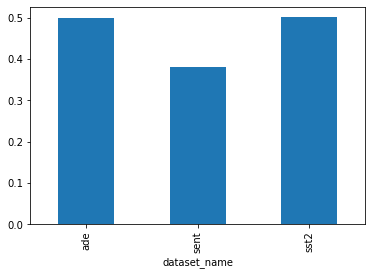

In [26]:
result_df_fewshot.groupby('dataset_name')['accuracy'].mean().plot(kind='bar')

In [29]:
pd.DataFrame(result_df_fewshot.groupby('dataset_name')['accuracy'].mean())

,accuracy
dataset_name,
ade,0.498333
sent,0.379814
sst2,0.500824


In [21]:
result_df_fewshot.to_csv('Results_DF/result_df_finetune_bert_fewshot.csv', index=False)

In [ ]:
result_df_fulldata = run_experiment_finetune_bert(seed  ..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................b bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb bgtgttgttttttttttttttttttttttttt5tg5t5t5gt54t5tt54t54gt54t54g4t544t54g4t4t54gf4t54g4t444444445t44554544454554t454tgot54tg5t4g5t4g5t4gfrg5t4gfr54tgfr4tgr55t4gg4tgtgrgrf5t4gfr4tg44tttttttt4tttttttt44tg44tg44tttttttt4tgrtgtttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttg44tg44tttttttt4tttttttt4ttttttt4ttttttt4ttttttttt4ttttttttttt4ttttttttt44t44t44t44t44t44t44t44tt4tttt4ttttt4tttttttt4tttttt4ttttt4ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt45ttttttttttttttttttttt5tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt55555555555555555555555555555555555555555555t4444t44444444444444444444444444444444444444444444444444444444t4t4444t4444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444tttttttt4tttttttttt44444444t44444444t44444444t444t44tt44tt44t44t44ttttt4t44ttttt4ttttttttttttttttttttte4tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttetttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttetttttttttttttttttttetettttetetttttttttttttttttttttttttttttttttttttttttttetttttttttttttttttttttttttettttttttttttttttttttttttttettttttttetttttttttttttttttttetttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888ns, dataset_dic, nr_ex_class, get_full_data=True)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-14220f8355f179b7.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-0428d00cbcf85dc4.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-cd13bd2b15047e7b.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_cla

1000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy
50,0.581700,0.452605,0.805000
100,0.396900,0.356549,0.848000


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-f686891631dc789e.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-ca7cfbe41b2fcd44.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-9c30c024bfa9091e.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-7fc3bed35e498

1000


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

Step,Training Loss,Validation Loss,Accuracy
50,0.562800,0.449096,0.817000
100,0.425300,0.380006,0.841667


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


 33%|█████████████████████████                                                  | 1/3 [10:12:49<20:25:38, 36769.06s/it]Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-b717d0ded2ff2a16.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--SentEval-CR-c9aa0d3185fe82a0\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-e38794c6000ac5de.arrow


1000


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Step,Training Loss,Validation Loss,Accuracy
50,0.567700,1.207286,0.379814
100,0.405700,1.431172,0.379814


***** Running Evaluation *****
  Num examples = 753
  Batch size = 8
***** Running Evaluation *****
  Num examples = 753
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
***** Running Evaluation *****
  Num examples = 753
  Batch size = 8


Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-cbc899390741d749.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--SentEval-CR-c9aa0d3185fe82a0\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-475e942e7d5a1864.arrow


1000


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\loriz/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

Step,Training Loss,Validation Loss,Accuracy
50,0.600500,1.024042,0.379814


***** Running Evaluation *****
  Num examples = 753
  Batch size = 8
